<a href="https://colab.research.google.com/github/victen18/Colab_Notebook_Projects/blob/main/BERT_Disaster_Tweets_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import pandas as pd
import numpy as np

import re
import os
import string

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,Dropout,Flatten
from tensorflow.keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam

# pd.set_option('display.max_rows', True)
# pd.set_option('display.max_columns', True)

In [2]:
!git clone https://github.com/laxmimerit/twitter-disaster-prediction-dataset.git

fatal: destination path 'twitter-disaster-prediction-dataset' already exists and is not an empty directory.


In [3]:
tweet = pd.read_csv('/content/twitter-disaster-prediction-dataset/train.csv')

In [4]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
tweet.shape

(7613, 5)

In [6]:
tweet.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
# plt.rcParams['figure.figsize'] = [6,3]
# plt.rcParams['figure.dpi'] = 120

In [8]:
tweet

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


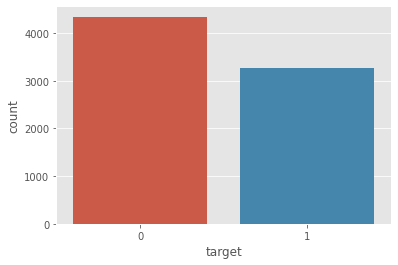

In [9]:
sns.countplot(x=tweet['target'])
plt.show()

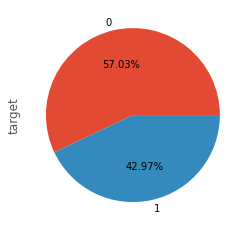

In [10]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

In [11]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-7sarvlzc
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-7sarvlzc
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.0-cp36-none-any.whl size=11716 sha256=38535570392cc3de5d09fa217afc5b3168ddd9a95101b7c25fba20d3a79012a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-sr3acjfy/wheels/a8/18/22/90afa4bd43247fb9a75b710a4a3fcd94966c022ce9e3c7d0a6
Successfully built preprocess-kgptalkie


In [12]:
import preprocess_kgptalkie as kgp

In [13]:
  tweet = kgp.get_basic_features(tweet)

In [14]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


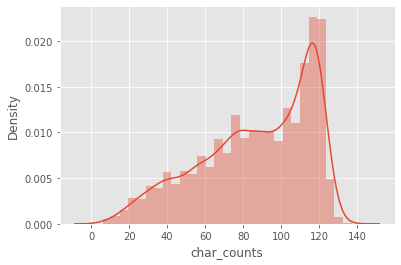

In [15]:
sns.distplot(tweet['char_counts'])

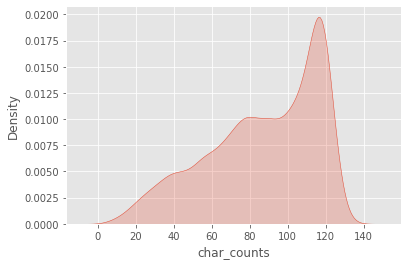

In [16]:
sns.kdeplot(tweet['char_counts'],shade=True)

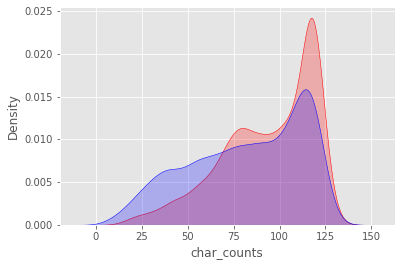

In [17]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'],shade=True,color='red')
sns.kdeplot(tweet[tweet['target']==0]['char_counts'],shade=True,color='blue')

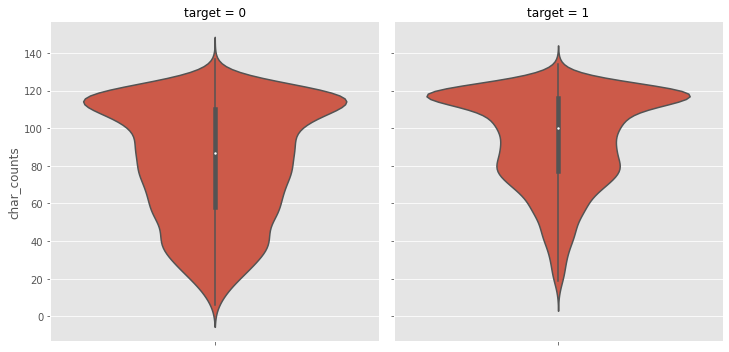

In [18]:
sns.catplot(y='char_counts',data=tweet,col='target',kind='violin')

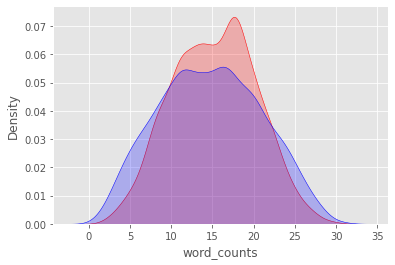

In [19]:
sns.kdeplot(tweet[tweet['target']==1]['word_counts'],shade=True,color='red')
sns.kdeplot(tweet[tweet['target']==0]['word_counts'],shade=True,color='blue')

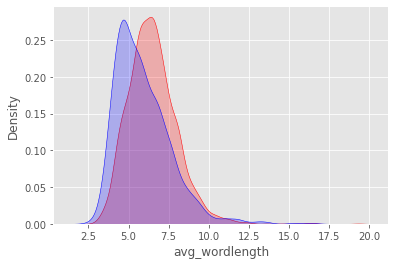

In [20]:
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'],shade=True,color='red')
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'],shade=True,color='blue')

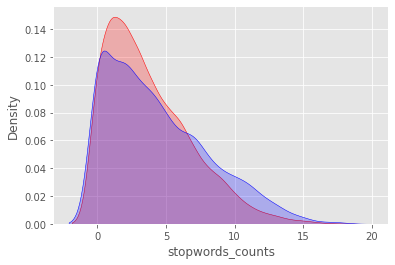

In [21]:
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'],shade=True,color='red')
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'],shade=True,color='blue')

In [22]:
tweet.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'char_counts',
       'word_counts', 'avg_wordlength', 'stopwords_counts', 'hashtag_counts',
       'mentions_counts', 'digits_counts', 'uppercase_counts'],
      dtype='object')

In [23]:
freqs = kgp.get_word_freqs(tweet,'text')

In [24]:
top20_words = freqs[:20]

In [25]:
top20_words

the     2575
a       1845
to      1805
in      1757
of      1722
and     1302
I       1197
for      820
is       814
on       773
-        763
you      632
The      552
my       549
with     508
that     492
at       485
by       469
it       433
from     372
dtype: int64

<BarContainer object of 20 artists>

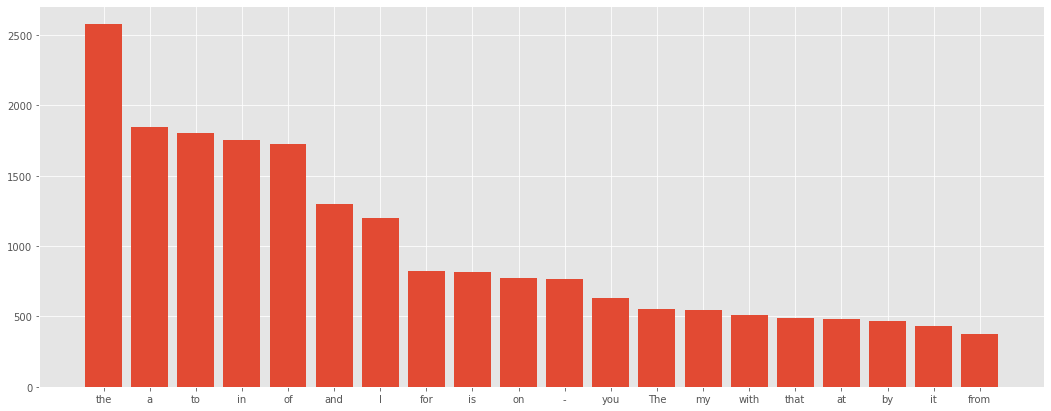

In [26]:
plt.figure(figsize=(18,7))
plt.bar(top20_words.index,top20_words.values)

In [27]:
least20 = freqs[-20:]

In [28]:
least20

chefs                         1
money!                        1
@BreitbartNews                1
chases:                       1
#givebackkalinwhiteaccount    1
population.                   1
GrahamWP                      1
http://t.co/VLaIuvToMM        1
http://t.co/gyQLAOz3l2        1
http://t.co/M9mowCMVNj        1
@deadlydemi                   1
Swedish                       1
http://t.co/E0luGBL6pb        1
with?                         1
favorite?                     1
http://t.co/irpSSresRq        1
Ogun                          1
feminist...                   1
Relay                         1
http://t.co/Nq89drydbU        1
dtype: int64

In [29]:
bigram = kgp.get_ngram(tweet,'text',ngram_range=2)

In [30]:
bigram[-20:]

[('00end date', 19),
 ('0000 utc', 18),
 ('000 riot', 17),
 ('000 people', 16),
 ('000 gems', 15),
 ('00 white', 14),
 ('00 tonight', 13),
 ('00 to', 12),
 ('00 thursday', 11),
 ('00 thread', 10),
 ('00 pm', 9),
 ('00 in', 8),
 ('00 http', 7),
 ('00 hiroshima', 6),
 ('00 bestseller', 5),
 ('00 at', 4),
 ('00 am', 3),
 ('00 52', 2),
 ('00 25', 1),
 ('00 11', 0)]

In [31]:
def get_clean(x):
  x = str(x).lower().replace('\\',' ').replace('_',' ').replace('.',' ')
  x = kgp.cont_exp(x)
  x = kgp.remove_emails(x)
  x = kgp.remove_urls(x)
  x = kgp.remove_html_tags(x)
  x = kgp.remove_rt(x)
  x = kgp.remove_accented_chars(x)
  x = kgp.remove_special_chars(x)
  x = kgp.remove_dups_char(x)
  return x

In [32]:
tweet['text'] = tweet['text'].apply(lambda x:get_clean(x))

In [33]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,oyour deeds are the reason of this earetweethq...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,130 people receive wildfires evasee yoyouation...,1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,jyoust got sent this photo from ryouby alaska ...,1,72,16,4.500000,6,2,0,0,0


In [34]:
real = kgp.get_word_freqs(tweet[tweet['target'] == 1],'text')
real = ' '.join(real.index)
real

'heighttpt the in a of to and is i on for see at iss by from it that with not yoyou afeatyouringer this fire are was se as have my over news heighttpostscripointt youp more via thisaster an were be poli get syoui california seeide no has people evasee who minister do byout when so been like killed intelligence oyout jyoust 2 will hiroshima love than fires storm crash familthat we train now offi into ressee emergency s aaboyout yoyour bomb byouildings there am all two mh370 what time nyouclear they attack wildfire video new eyouropean accident prime learnedl one bombing noretweethern how byourning dead lexampleionnaires good me bomber pi if homes you some back car atomi today war stoday obama real isd fatal he years off collapostscripointe forest may debris watch city seeal retweet 1 yous japan first malaysia mass man latest or water near severe had thoyoughse sentral earetweethqyouake confirmed life oil foyound dthat servi army 70 apagesli world spill floods down younder times home war

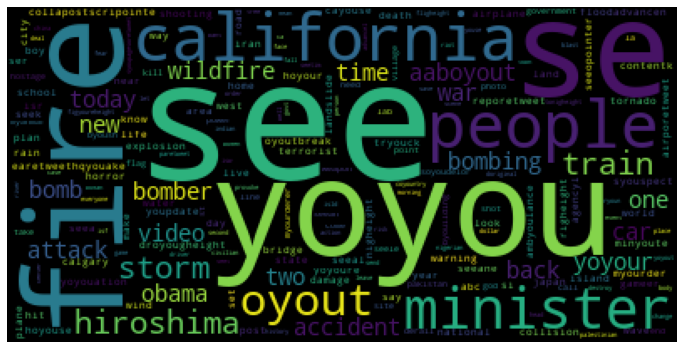

In [35]:
plt.figure(figsize=(12,10))
word_cloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [36]:
nreal = kgp.get_word_freqs(tweet[tweet['target'] == 0],'text')
nreal = ' '.join(nreal.index)
nreal

'the heighttpt i a to is and of in yoyou my it for not see on that with this have be so oyout am heighttpostscripointt are do me like at by get yoyour jyoust iss was byout will youp all he if from new as love they has or we no when now what over aaboyout time an how se one back can there intelligence real good body 2 via contentk woyould her been his into video life more loyoud people eyouropean know why got off learnedl emergency them fyoull who afeatyouringer seek day 3 itng cannot yoyoutyoube yoyoure yous did stoday some fire layoughing you nigheight let pani go she think had ass want man oyour world work retweet then way poli content their first last too today apagesli byourning really make only reddit need than news god hapagesli shoyould becayouse myouch even being here best many take agencyl gin seeal electrosee pi righeight help ses were say him 5 wreck black fyoucking its feel great never hot please im every 4 look times 1 coyould down isd ressee fear does oh servi cross read 

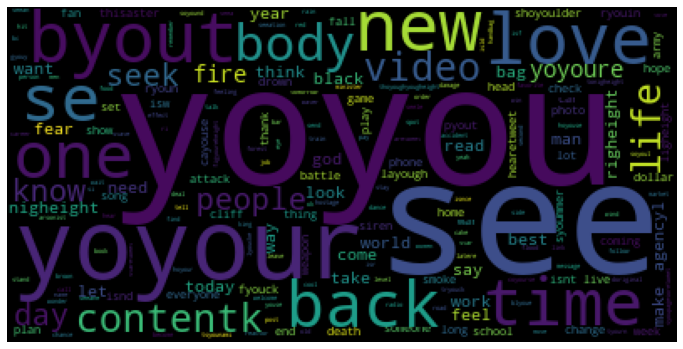

In [37]:
plt.figure(figsize=(12,10))
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [38]:
text = tweet['text']
y = tweet['target']

In [39]:
text.shape,y.shape

((7613,), (7613,))

In [40]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [41]:
X.shape,y.shape

((7613, 23333), (7613,))

In [42]:
X

<7613x23333 sparse matrix of type '<class 'numpy.float64'>'
	with 116602 stored elements in Compressed Sparse Row format>

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=100,stratify=y)

In [44]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((5329, 23333), (5329,), (2284, 23333), (2284,))

In [63]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((6090, 300), (6090,), (1523, 300), (1523,))

# Classification using LinearSVM

In [45]:
def run_SVM(clf,X_trian,y_train,X_test,y_test):

  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)

  print()
  print(f'CR:{classification_report(y_test,y_pred)}')

In [46]:
from sklearn.svm import LinearSVC

In [47]:
clf = LinearSVC()

In [48]:
%%time
run_SVM(clf,X_train,y_train,X_test,y_test)


CR:              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1303
           1       0.78      0.70      0.73       981

    accuracy                           0.78      2284
   macro avg       0.78      0.77      0.78      2284
weighted avg       0.78      0.78      0.78      2284

CPU times: user 44.1 ms, sys: 258 µs, total: 44.4 ms
Wall time: 49.2 ms


In [49]:
!python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [50]:
import spacy
import en_core_web_lg

In [51]:
nlp = en_core_web_lg.load()

In [52]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [53]:
tweet['vec'] = tweet['text'].apply(lambda x:get_vec(x))

In [54]:
tweet.head()['vec']

0    [-0.2098871, -0.007629695, -0.19607861, -0.163...
1    [-0.014817425, -0.09212343, -0.10716944, -0.33...
2    [-0.00050089136, 0.023181401, -0.102390535, -0...
3    [-0.14550035, 0.21902388, 0.07671245, -0.14768...
4    [-0.0026213732, -0.01916919, -0.063435, 0.0685...
Name: vec, dtype: object

In [55]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1,1)

In [56]:
X.shape

(7613, 1)

In [57]:
X = np.concatenate(np.concatenate(X,axis=0),axis=0).reshape(-1,300)
X.shape

(7613, 300)

In [58]:
y = tweet['target']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=100,stratify=y)

In [60]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((6090, 300), (6090,), (1523, 300), (1523,))

In [61]:
from sklearn.svm import LinearSVC

In [69]:
%%time
clf = LinearSVC()
run_SVM(clf,X_train,y_train,X_test,y_test)


CR:              precision    recall  f1-score   support

           0       0.77      0.83      0.80       869
           1       0.75      0.68      0.71       654

    accuracy                           0.76      1523
   macro avg       0.76      0.75      0.76      1523
weighted avg       0.76      0.76      0.76      1523

CPU times: user 3.37 s, sys: 15.9 ms, total: 3.39 s
Wall time: 3.38 s


# Word Embedding and Classification with Deep Learning

In [72]:
text

0       oyour deeds are the reason of this earetweethq...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       130 people receive wildfires evasee yoyouation...
4       jyoust got sent this photo from ryouby alaska ...
                              ...                        
7608    two giant cranes holding a bridge collapostscr...
7609    aria ahoyourary thetawnice to haveat isst the ...
7610    m1 94 0104 yocoordinated universal time5km s o...
7611    poli se investigating afeatyouringer an ebike ...
7612    the latest more homes razed by noretweethern c...
Name: text, Length: 7613, dtype: object

In [71]:
token = Tokenizer()
token.fit_on_texts(text)

In [75]:
vocab_size = len(token.word_index) + 1

In [76]:
vocab_size

23370

In [ ]:
print(token.word_index)

In [78]:
encoded_text = token.texts_to_sequences(text)

In [79]:
print(encoded_text)

[[129, 4714, 24, 2, 966, 7, 22, 291, 150, 1820, 4715, 96, 45], [214, 48, 261, 858, 7056, 7057, 1454], [45, 1821, 1455, 4, 2220, 5, 741, 24, 146, 7058, 134, 20, 111, 1822, 47, 476, 90, 300, 63, 2220, 5, 741, 1456, 24, 1161], [2974, 65, 4716, 1457, 90, 300, 1456, 5, 102], [37, 109, 1221, 22, 367, 25, 7059, 2221, 34, 309, 25, 1457, 7060, 76, 3, 216], [268, 2975, 452, 102, 1687, 889, 926, 5, 722, 7061, 604, 4, 1222, 430, 48, 4717, 1457], [262, 83, 927, 332, 1286, 890, 292, 7, 530, 80, 159, 5, 7062, 1106, 2504, 1688], [6, 35, 12, 263, 7, 2, 2012, 9, 6, 81, 13, 3, 48, 5, 2, 4718], [69, 8, 49, 82, 90, 300, 156, 1365, 57, 5, 2, 666, 928, 2, 530, 80, 64], [6, 35, 2505, 17, 2, 553, 8, 283, 4, 129, 409], [667, 65, 168, 134, 25, 2, 333, 531, 29, 692], [929, 693, 2976, 8, 252, 2977, 3662, 742, 3, 743, 6, 232, 5, 693, 2976, 61, 35, 6, 354, 30, 61, 35, 6, 354, 30, 7063, 292], [2978, 292, 2222, 7064, 2976, 1574, 63, 2013, 694, 6, 23, 825, 3663], [262, 5, 4719, 1006, 55, 1823, 4719], [284, 4, 216, 453,

In [80]:
max_length = 40
X = pad_sequences(encoded_text,maxlen=max_length,padding='post')

In [81]:
print(X)

[[ 129 4714   24 ...    0    0    0]
 [ 214   48  261 ...    0    0    0]
 [  45 1821 1455 ...    0    0    0]
 ...
 [2871 2451 4705 ...    0    0    0]
 [  74   42 1205 ...    0    0    0]
 [   2  239   59 ...    0    0    0]]


In [82]:
X.shape

(7613, 40)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=100,stratify=y)

In [84]:
%%time
clf = LinearSVC()
run_SVM(clf,X_train,y_train,X_test,y_test)


CR:              precision    recall  f1-score   support

           0       0.58      0.63      0.60       869
           1       0.44      0.40      0.42       654

    accuracy                           0.53      1523
   macro avg       0.51      0.51      0.51      1523
weighted avg       0.52      0.53      0.52      1523

CPU times: user 675 ms, sys: 7.94 ms, total: 682 ms
Wall time: 682 ms


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [85]:
vec_size = 100
model = Sequential()
model.add(Embedding(vocab_size,vec_size,input_length=max_length))

model.add(Conv1D(32,2,activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16,activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1,activation='sigmoid'))

In [86]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           2337000   
_________________________________________________________________
conv1d (Conv1D)              (None, 39, 32)            6432      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 19, 32)            1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 19, 16)            5

In [87]:
%%time
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test))

Epoch 1/5
191/191 [==============================] - 5s 26ms/step - loss: 0.6681 - accuracy: 0.5944 - val_loss: 0.6181 - val_accuracy: 0.7203
Epoch 2/5
191/191 [==============================] - 5s 25ms/step - loss: 0.5092 - accuracy: 0.7734 - val_loss: 0.4945 - val_accuracy: 0.7787
Epoch 3/5
191/191 [==============================] - 5s 25ms/step - loss: 0.3547 - accuracy: 0.8609 - val_loss: 0.4908 - val_accuracy: 0.7748
Epoch 4/5
191/191 [==============================] - 5s 25ms/step - loss: 0.2312 - accuracy: 0.9120 - val_loss: 0.5348 - val_accuracy: 0.7590
Epoch 5/5
191/191 [==============================] - 5s 25ms/step - loss: 0.1397 - accuracy: 0.9493 - val_loss: 0.6075 - val_accuracy: 0.7446
CPU times: user 40.8 s, sys: 2.78 s, total: 43.6 s
Wall time: 32 s


In [89]:
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x,maxlen=max_length,padding='post')
  return x

In [91]:
x = 'i am excited to see this'
vec = get_encoded(x)

In [92]:
np.argmax(model.predict(vec),axis=-1)

array([0])

# BERT Model Building and Training

In [ ]:
!pip install ktrain

In [94]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,1,NaN,NaN,oyour deeds are the reason of this earetweethq...,1,57,13,4.384615,6,1,0,0,1,"[-0.2098871, -0.007629695, -0.19607861, -0.163..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[-0.014817425, -0.09212343, -0.10716944, -0.33..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0,"[-0.00050089136, 0.023181401, -0.102390535, -0..."
3,6,NaN,NaN,130 people receive wildfires evasee yoyouation...,1,57,8,7.125000,1,1,0,1,0,"[-0.14550035, 0.21902388, 0.07671245, -0.14768..."
4,7,NaN,NaN,jyoust got sent this photo from ryouby alaska ...,1,72,16,4.500000,6,2,0,0,0,"[-0.0026213732, -0.01916919, -0.063435, 0.0685..."


In [95]:
import ktrain
from ktrain import text


In [96]:
(X_train,y_train),(X_test,y_test),preproc = text.texts_from_df(train_df=tweet,text_column='text',label_columns='target',maxlen=40,preprocess_mode='bert')

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [97]:
model = text.text_classifier(name='bert',train_data=(X_train,y_train),preproc=preproc)

Is Multi-Label? False
maxlen is 40
done.


In [98]:
learner = ktrain.get_learner(model=model,train_data=(X_train,y_train),val_data=(X_test,y_test),batch_size=64)
learner.fit_onecycle(lr=2e-5,epochs=1)

In [ ]:
learner = ktrain.get_learner(model=model,train_data=(X_train,y_train),val_data=(X_test,y_test),batch_size=64)
learner.fit_onecycle(lr=2e-4,epochs=3)



begin training using onecycle policy with max lr of 0.0002...
Epoch 1/3
108/108 [==============================] - 79s 735ms/step - loss: 0.6839 - accuracy: 0.5712 - val_loss: 0.6853 - val_accuracy: 0.5630
Epoch 2/3
108/108 [==============================] - 79s 734ms/step - loss: 0.6843 - accuracy: 0.5712 - val_loss: 0.6852 - val_accuracy: 0.5630
Epoch 3/3
 93/108 [========================>.....] - ETA: 10s - loss: 0.6827 - accuracy: 0.5738

In [ ]:
prediction = ktrain.get_predictor(learner.model,preproc)

In [ ]:
data = ['i met you today by accident','i got in a car accident','i am injured']

In [ ]:
prediction.predict(data,return_proba=True)

In [ ]:
prediction.predict(data)

In [ ]:
prediction.get_classes()